In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import shap
from PyALE import ale
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
import dtreeviz
import graphviz
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

In [ ]:
df = pd.read_pickle("modeling.pkl")

In [ ]:
# Process and clean the data. Requires csv files to be located in a folder called "CSV" in the directory of the notebook.
def process_data():        
    # Load the data
    df_signals_2016 = pd.read_csv('CSV\wind-farm-signals-2016.csv', sep=';')
    df_signals_2017 = pd.read_csv('CSV\wind-farm-signals-2017.csv', sep=';')
    df_metmast_2016 = pd.read_csv('CSV\wind-farm-metmast-2016.csv', sep=';')
    df_metmast_2017 = pd.read_csv('CSV\wind-farm-metmast-2017.csv', sep=';')
    #df_powercurve = pd.read_excel('powercurve.xlsx')
    
    # Merge dataframes
    frames1 = [df_signals_2016, df_signals_2017]
    df1 = pd.concat(frames1, ignore_index=True)
    # Convert to datetime and remove time zone
    df1['Timestamp'] = pd.to_datetime(df1['Timestamp']).dt.tz_localize(None)

    frames2 = [df_metmast_2016, df_metmast_2017]
    df2 = pd.concat(frames2, ignore_index=True)
    df2['Timestamp'] = pd.to_datetime(df2['Timestamp']).dt.tz_localize(None)

    # Join dataframes on index 'Timestamp'
    df = df1.set_index('Timestamp').join(df2.set_index('Timestamp'))

    # Select turbine
    turbine = 'T07'
    df = df.loc[df['Turbine_ID'] == turbine].reset_index()

    # Extract only relevant columns
    df = df[['Timestamp', 'Turbine_ID', 'Gen_Bear_Temp_Avg', 'Gen_RPM_Avg', 
             'Nac_Temp_Avg', 'Amb_WindSpeed_Avg', 'Avg_Humidity', 
             'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 
            # 'Amb_WindDir_Abs_Avg', 'Grd_Prod_Pwr_Avg'
            ]].copy()

    # Rename columns
    df = df.rename(columns={'Timestamp': 'Date',
                            'Gen_Bear_Temp_Avg': 'Gen_Bear_Temp',
                            'Gen_RPM_Avg': 'Gen_RPM',
                            #'Gen_Bear2_Temp_Avg': 'Gen_Bear2_Temp',
                            'Nac_Temp_Avg': 'Nac_Temp', 
                            'Amb_WindSpeed_Avg': 'Wind_Speed', 
                            'Avg_Humidity': 'Humidity',
                            'Gen_Phase1_Temp_Avg': 'Gen_Phase1_Temp', 
                            'Gen_Phase2_Temp_Avg': 'Gen_Phase2_Temp',
                            'Gen_Phase3_Temp_Avg': 'Gen_Phase3_Temp', 
                            'Amb_WindDir_Abs_Avg' : 'Wind_Dir',
                            'Grd_Prod_Pwr_Avg': 'Prod_Pwr'})

    df['Gen_Phase_Temp'] = df[['Gen_Phase1_Temp', 'Gen_Phase2_Temp', 'Gen_Phase3_Temp']].mean(axis=1)
    df = df.drop(columns=['Gen_Phase1_Temp', 'Gen_Phase2_Temp', 'Gen_Phase3_Temp'])

    # Fill the missing Gen_Bear_Temp nan value with the the mean of the values diorectly next to it
    df.Gen_Bear_Temp = df.Gen_Bear_Temp.fillna(48)
    df = df.loc[df['Gen_Bear_Temp'] < 100]

    # Combine duplicates by their mean
    df = df.groupby('Date').mean()
    df = df.round(1)
    
    return df

In [ ]:
# Create dataframe
df = process_data()
df.to_pickle("modeling.pkl")

In [ ]:
# Plot train/test split
train = df.loc[df.index < '2017']
test = df.loc[df.index >= '2017']

fig, ax = plt.subplots(figsize=(15,7))
train.Gen_Bear_Temp.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.Gen_Bear_Temp.plot(ax=ax, label='Test Set')
ax.axvline('2017', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
ax.set_ylabel('Generator bearing temperature ($^\circ$C)')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

plt.show()

In [ ]:
# Plot train/validation/test split
train = df.loc[df.index < '2016-09']
test = df.loc[df.index >= '2017']
cv = df.loc[(df.index >= '2016-09') & (df.index < '2017')]

fig, ax = plt.subplots(figsize=(15,7))
train.Gen_Bear_Temp.plot(ax=ax, label='Training Set', title='Data Train/Validation/Test Split')
cv.Gen_Bear_Temp.plot(ax=ax, label='Cross Validation Set')
test.Gen_Bear_Temp.plot(ax=ax, label='Test Set')
ax.axvline('2017', color='black', ls='--')
ax.axvline('2016-09', color='black', ls='--')
ax.legend(['Training Set', 'Validation Set', 'Test Set'])
ax.set_ylabel('Generator bearing temperature ($^\circ$C)')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

plt.show()

In [ ]:
# Plot cross validation folds
import matplotlib.dates as mdates

tss = TimeSeriesSplit(n_splits=4, test_size=6*24*30, gap=6*24)

fig, axs = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

CV = df.loc[df.index < '2017'].copy()
fold = 0
for train_idx, val_idx in tss.split(CV):
    train = CV.iloc[train_idx]
    test = CV.iloc[val_idx]
    train['Gen_Bear_Temp'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Gen_Bear_Temp'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    axs[fold].xaxis.set_major_locator(mdates.MonthLocator())

    fold += 1

plt.show()

# Training models

In [178]:
# Split data
FEATURES = ['Gen_RPM', 'Nac_Temp', 'Wind_Speed', 'Humidity', 'Gen_Phase_Temp']
TARGET = 'Gen_Bear_Temp'

df = pd.read_pickle("modeling.pkl")
train = df.loc[df.index < '2017'].copy()
test = df.loc[df.index >= '2017'].copy()
cv = df.loc[(df.index > '2017') & (df.index < '2017-06')]

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [16]:
# Train XGBoost ML model
XGB = xgb.XGBRegressor(booster='gbtree',    
                       n_estimators=600,
                       objective='reg:squarederror',
                       max_depth=5,
                       learning_rate=0.01,
                       random_state=42)

XGB.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:44.97290	validation_1-rmse:46.10008
[100]	validation_0-rmse:16.59221	validation_1-rmse:16.90851
[200]	validation_0-rmse:6.28852	validation_1-rmse:6.34603
[300]	validation_0-rmse:2.72132	validation_1-rmse:2.81795
[400]	validation_0-rmse:1.69993	validation_1-rmse:1.98491
[500]	validation_0-rmse:1.48416	validation_1-rmse:1.87343
[599]	validation_0-rmse:1.43302	validation_1-rmse:1.84655


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=600, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [64]:
# Train HGBR ML model
HGBR = HistGradientBoostingRegressor(max_depth=5,
                                    learning_rate=0.1,
                                    random_state=42)

HGBR.fit(X_train, y_train)

HistGradientBoostingRegressor(max_depth=5, max_leaf_nodes=10, random_state=42)

In [6]:
# Train LightGBM ML model
LGB = lgb.LGBMRegressor(objective='regression',
                         n_estimators=600,
                         max_depth=3,
                         learning_rate=0.1,
                         num_leaves=50,
                         min_data_in_leaf=100,
                         random_state=42)

LGB.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False)

C:\Users\Oliver\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


LGBMRegressor(max_depth=3, min_data_in_leaf=100, n_estimators=600,
              num_leaves=50, objective='regression', random_state=42)

In [177]:
X_train_dropped = train.dropna()[FEATURES]
y_train_dropped = train.dropna()[TARGET]

X_test_dropped = test.dropna()[FEATURES]
y_test_dropped = test.dropna()[TARGET]

RF = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 42).fit(X_train_dropped, y_train_dropped)

In [ ]:
# Cross validate model on folds plotted above
model = LGB
tss = TimeSeriesSplit(n_splits=4, test_size=6*24*30, gap=6*24)
CV = df.loc[df.index < '2017'].copy()
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(CV):
    
    train = CV.iloc[train_idx]
    test = CV.iloc[val_idx]
    
    FEATURES = ['Gen_RPM', 'Nac_Temp', 'Wind_Speed', 'Humidity', 'Gen_Phase_Temp']
    TARGET = 'Gen_Bear_Temp'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

#     model.fit(X_train, y_train,
# #            eval_set=[(X_train, y_train), (X_test, y_test)],
#             verbose=100)
    
#     model.fit(X_train, y_train)
    
    LGB.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=False)

    y_pred = model.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    
print(f'Score across folds {np.mean(scores):0.2f}')
print(f'Fold scores:{scores}')

# Predictions

In [185]:
# Function for creating predictions
def predict(models):
    for model in models:
        if model == 'XGB':
            test['XGB'] = XGB.predict(X_test)
            test['XGB'] = test['XGB'].astype('float64')
        if model == 'HGBR':
            test['HGBR'] = HGBR.predict(X_test)
        if model == 'LGB':
            test['LGB'] = LGB.predict(X_test)
#         if model == 'RF':
#             test['RF'] = RF.predict(X_test_dropped)

In [186]:
# Predicting and adding predictions to main dataframe
models = 'XGB', 'HGBR', 'LGB'
predict(models)
test = test.round(1)
df = pd.read_pickle("modeling.pkl")
df = df.merge(test[['XGB']], how='left', left_index=True, right_index=True).copy()
df = df.merge(test[['HGBR']], how='left', left_index=True, right_index=True).copy()
df = df.merge(test[['LGB']], how='left', left_index=True, right_index=True).copy()
# df = df.merge(test[['RF']], how='left', left_index=True, right_index=True, on=df.index).copy()

# Metrics

In [188]:
# Function for calculating metrics of ML models
def metric(models):
    for model in models:
        MSE = mean_squared_error(test[TARGET], test[model])
        RMSE = np.sqrt(mean_squared_error(test[TARGET], test[model]))
        MAE = mean_absolute_error(test[TARGET], test[model])
        MAPE = mean_absolute_percentage_error(test[TARGET], test[model])
        R2 = r2_score(test[TARGET], test[model])
        
        metrics.loc[model] = MSE, RMSE, MAE, MAPE, R2
    
    return metrics

In [189]:
# Add metrics to dataframe
cols = ['MSE', 'RMSE', 'MAE', 'MAPE', 'R2']
metrics = pd.DataFrame(index=models, columns=cols)
metrics = metric(models).astype('float').round(2)

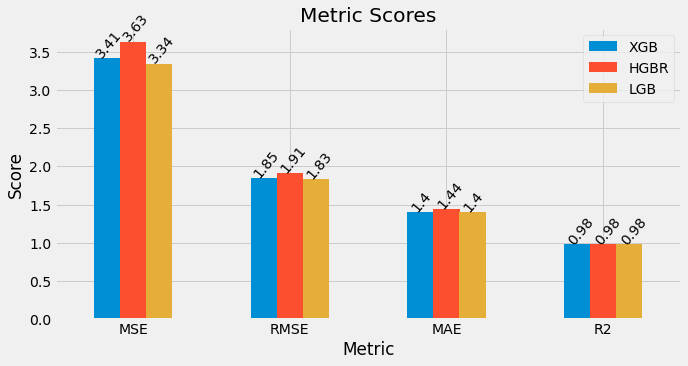

In [190]:
# Plot metrics
ax = metrics.drop(columns='MAPE').T.plot(kind='bar', figsize=(10,5), title='Metric Scores', xlabel='Metric', ylabel='Score')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005), rotation=50)

plt.xticks(rotation=0)
plt.show()

In [ ]:
# Make custom prediction with features in following order: 
#'Gen_RPM', 'Nac_Temp', 'Wind_Speed', 'Humidity','Gen_Phase_Temp'
LGB.predict(np.array([1000, 70, 19, 47, 100]).reshape(1,-1))

# Hyperparameter tuning

In [7]:
# Function to select params to tune using GridSearch
def param_selection(model):
    if model == XGB:
        param_grid = {
            'max_depth': [2, 3, 4, 5],
            'learning_rate': [0.1, 0.01, 0.001, 0.0001],
            'n_estimators': range(500, 1100, 100),
            'min_child_weight': [1, 10, 100]}
        
    if model == HGBR:
        param_grid = {
            'max_depth': [2, 3, 4, 5],
            'learning_rate': [0.1, 0.01, 0.001],
            'max_leaf_nodes': [3, 10, 30]}
        
    if model == LGB:
        param_grid = {
            'max_depth': [2, 3, 4, 5],
            'learning_rate': [0.1, 0.01, 0.001],
            'n_estimators': range(500, 1000, 100),
            'num_leaves': range(50, 100, 10),
            'min_data_in_leaf': range(100, 1100, 200)}
        
    return param_grid

In [ ]:
# GridSearch to tune hyperparameters of selected model
model = HGBR
param_grid = param_selection(model)
tss = TimeSeriesSplit(n_splits=4, test_size=6*24*30, gap=6*24)

search = GridSearchCV(model, param_grid, cv=tss, verbose=3, n_jobs=-1)
search.fit(X_train, y_train)

grid = pd.DataFrame(search.cv_results_)

print(f"The best parameters are {search.best_params_} with a score of {round(search.best_score_, 2)}")
grid

In [22]:
# XGB The best parameters are {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 500} with a score of 0.99
# HGBR The best parameters are {'learning_rate': 0.1, 'max_depth': 5, 'max_leaf_nodes': 10} with a score of 0.98
# LGB The best parameters are {'learning_rate': 0.1, 'max_depth': 3, 'min_data_in_leaf': 100, 'n_estimators': 600, 'num_leaves': 50} with a score of 0.99

In [ ]:
# Plot real value vs predicted values
start = '2017-06-03'
end = '2017-06-12'

ax = df.loc[(df.index > start) & (df.index < end)]['Gen_Bear_Temp'].plot(figsize=(15, 5), title='Raw Data and Prediction')
df.loc[(df.index > start) & (df.index < end)]['XGB'].plot(style='.')
# df.loc[(df.index > start) & (df.index < end)]['HGBR'].plot(style='.')
# df.loc[(df.index > start) & (df.index < end)]['LGB'].plot(style='.')
df.loc[(df.index > start) & (df.index < end)]['RF'].plot(style='.')

plt.legend(['Measured','XGB', 'HGBR', 'LGB'])
plt.show()

In [ ]:
df.query('index > "2017-06-07 19" & index < "2017-06-07 23"')

In [ ]:
# Calculate error and show timestamps of largest errors
test['error_XGB'] = np.abs(test[TARGET] - test['XGB'])
test['error_HGBR'] = np.abs(test[TARGET] - test['HGBR'])
test['error_LGB'] = np.abs(test[TARGET] - test['LGB'])
test.error_XGB.sort_values(ascending=False).head(10)

# Shap

### Global explanations

In [191]:
# Fits the explainer
model = XGB
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

C:\Users\Oliver\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.


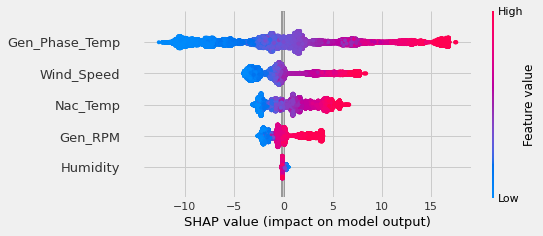

In [147]:
# Show global explanation
shap.summary_plot(shap_values, X_test)

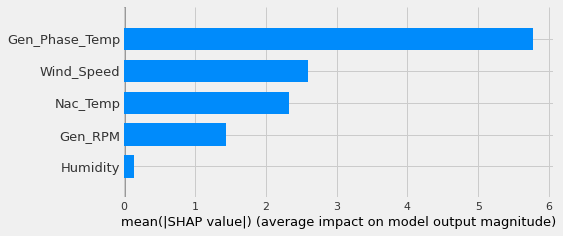

In [148]:
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_test, plot_type='bar')

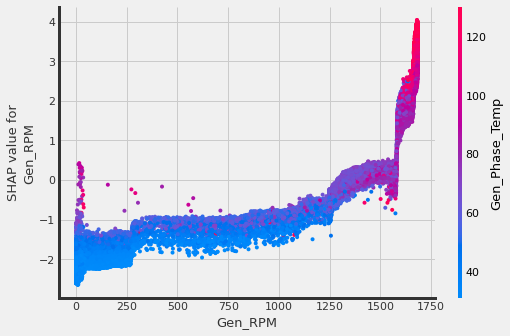

In [149]:
# Dependence plot:
shap.dependence_plot("Gen_RPM", shap_values, X_test)

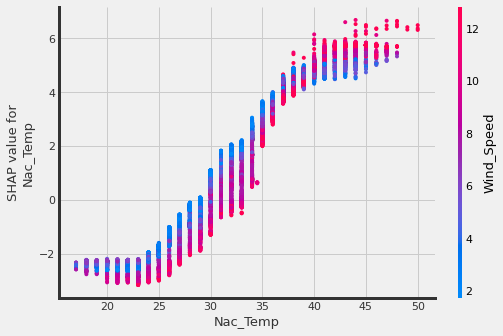

In [150]:
shap.dependence_plot("Nac_Temp", shap_values, X_test)

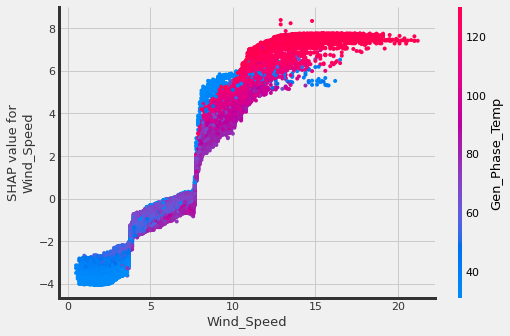

In [151]:
# Dependence plot:
shap.dependence_plot("Wind_Speed", shap_values, X_test)

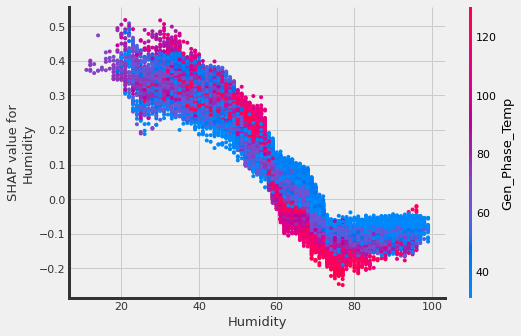

In [152]:
# Dependence plot:
shap.dependence_plot("Humidity", shap_values, X_test)

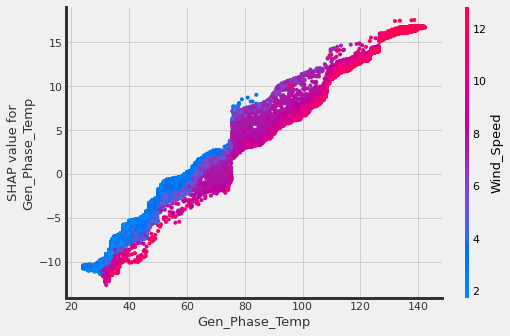

In [153]:
# Dependence plot:
shap.dependence_plot("Gen_Phase_Temp", shap_values, X_test)

### Interaction values

In [164]:
X_interaction = X_test.iloc[:1000,:]
shap_interaction_values = shap.TreeExplainer(rf).shap_interaction_values(X_interaction)

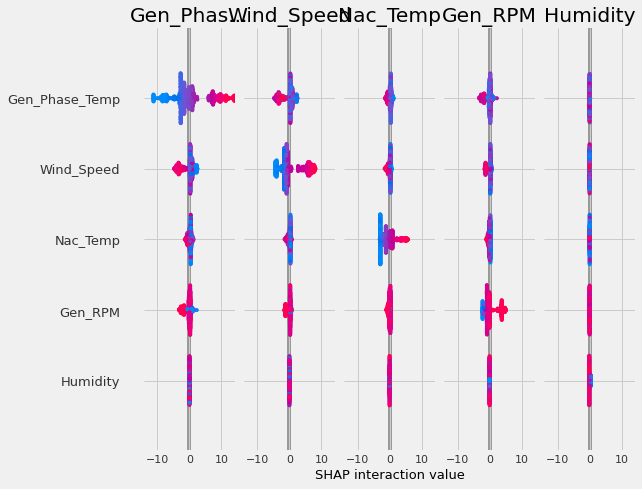

In [165]:
shap.summary_plot(shap_interaction_values, X_interaction)

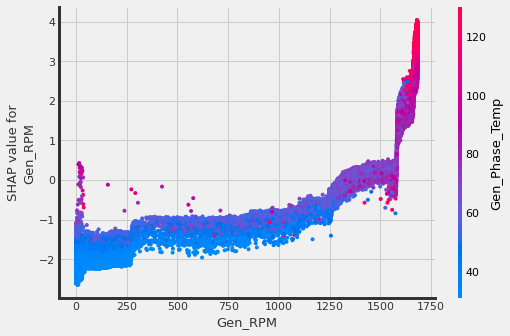

In [174]:
# Raw dependence plot:
shap.dependence_plot(("Gen_RPM"), shap_values, X_test)

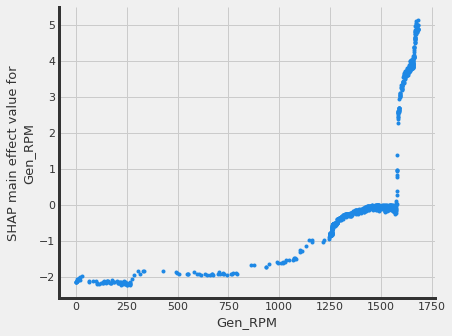

In [167]:
# Interaction values dependence plot capturing main effects:
shap.dependence_plot(("Gen_RPM", "Gen_RPM"), shap_interaction_values, X_interaction)

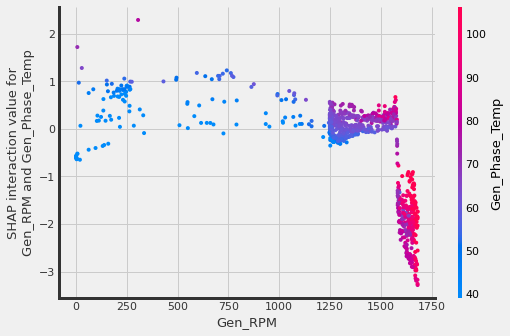

In [175]:
# Interaction values dependence plot capturing interaction effects:
shap.dependence_plot(("Gen_RPM", "Gen_Phase_Temp"), shap_interaction_values, X_interaction)

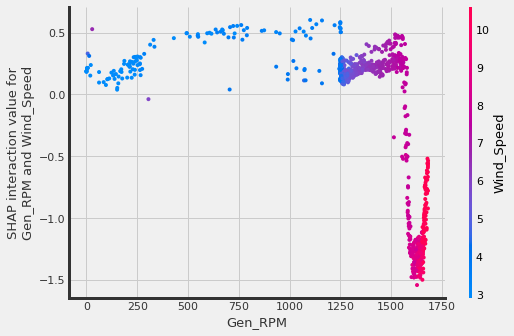

In [176]:
# Interaction values dependence plot capturing interaction effects:
shap.dependence_plot(("Gen_RPM", "Wind_Speed"), shap_interaction_values, X_interaction)

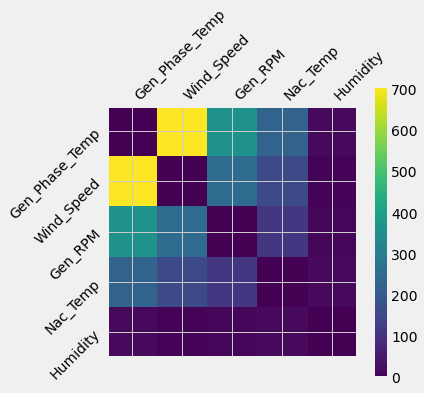

In [170]:
import matplotlib.pylab as pl
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
pl.figure(figsize=(5,5))
pl.imshow(tmp2)
pl.yticks(range(tmp2.shape[0]), X.columns[inds], rotation=45, horizontalalignment="right")
pl.xticks(range(tmp2.shape[0]), X.columns[inds], rotation=45, horizontalalignment="left")
pl.gca().xaxis.tick_top()
pl.colorbar()
pl.show()

### Local explanations

In [ ]:
import tempfile
from IPython.core.display import display, HTML

explainer = shap.TreeExplainer(XGB)
shap_values = explainer.shap_values(X_test)

shap.initjs()

def shap_deepnote_show(plot):
    tmp_output_filename = tempfile.NamedTemporaryFile(suffix='.html').name
    shap.save_html(tmp_output_filename, plot)

    f = open(tmp_output_filename, "r", encoding="utf-8")
    data = f.read()
    display(HTML(data))

In [ ]:
shap_deepnote_show(shap.force_plot(explainer.expected_value, shap_values[535], X_test.iloc[535].values, feature_names = X_test.columns))

In [ ]:
X_interaction = X_test.iloc[:1000,:]

explainer = shap.TreeExplainer(XGB, X_interaction)
shap_values = explainer(X_interaction)

In [ ]:
# Show local explanation
shap.plots.waterfall(shap_values[535,:])

# ALE

In [ ]:
# explanation for selected feature using ALE
model = LGB

## 1D - continuous - no CI
ale_eff = ale(
    X=X_test[FEATURES], model=model, feature=["Gen_Phase_Temp"], grid_size=50, include_CI=False
)

In [ ]:
# explanation for selected feature using ALE and confidence interval
## 1D - continuous - with 95% CI
import random
random.seed(123)
X_sample = X_test[FEATURES].loc[random.sample(X_test.index.to_list(), 1000), :]
ale_eff = ale(
    X=X_sample, model=model, feature=["Gen_RPM"], grid_size=50, include_CI=True, C=0.95
)

In [ ]:
# Plot two features and show their combiined effect on prediction
ale_eff = ale(X=X_test[FEATURES], model=model, feature=["Gen_Phase_Temp", "Gen_RPM"], grid_size=100)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df.Wind_Speed, lags=23, missing='drop', title='Wind Speed Autocorrelation')

from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df.Wind_Speed, lags=23, title='Wind Speed Partial Autocorrelation')

In [ ]:
def create_LSTM(input_nodes, hidden_nodes, output_nodes):
    model = Sequential()
    model.add(LSTM(hidden_nodes, input_shape=(1, input_nodes)))
    model.add(Dense(output_nodes))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

## dtreeviz

In [ ]:
viz_rmodel = dtreeviz.model(XGB,
                           X_train, y_train,
                           feature_names=FEATURES,
                           target_name=TARGET,
                           tree_index=1                        
                          )

#viz_rmodel.view(fancy=False)

In [ ]:
x = X_train.iloc[20000]
x

In [ ]:
viz_rmodel.view(show_just_path=True, x = x)

In [ ]:
#viz_rmodel.view(x = x)

In [ ]:
print(viz_rmodel.explain_prediction_path(x))

In [ ]:
viz_rmodel.leaf_sizes()

In [ ]:
viz_rmodel.rtree_leaf_distributions()

In [ ]:
viz_rmodel.node_stats(node_id=4)

In [42]:
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.dropna().values, feature_names=X_train.columns.values.tolist(),
                                                  class_names=[TARGET], verbose=True, mode='regression')

In [52]:
j = 300
exp = explainer.explain_instance(X_test.values[j], XGB.predict, num_features=len(FEATURES))

Intercept 44.62600990022762
Prediction_local [43.76982725]
Right: 40.287655


In [53]:
exp.show_in_notebook(show_table=True)

In [54]:
exp.as_list()

[('Nac_Temp <= 25.00', -4.235290890228883),
 ('61.70 < Gen_Phase_Temp <= 78.30', 3.3133812884094906),
 ('3.20 < Wind_Speed <= 5.30', -0.9374336654908876),
 ('254.15 < Gen_RPM <= 1270.50', 0.7741455772576161),
 ('71.00 < Humidity <= 82.00', 0.22901504415303373)]

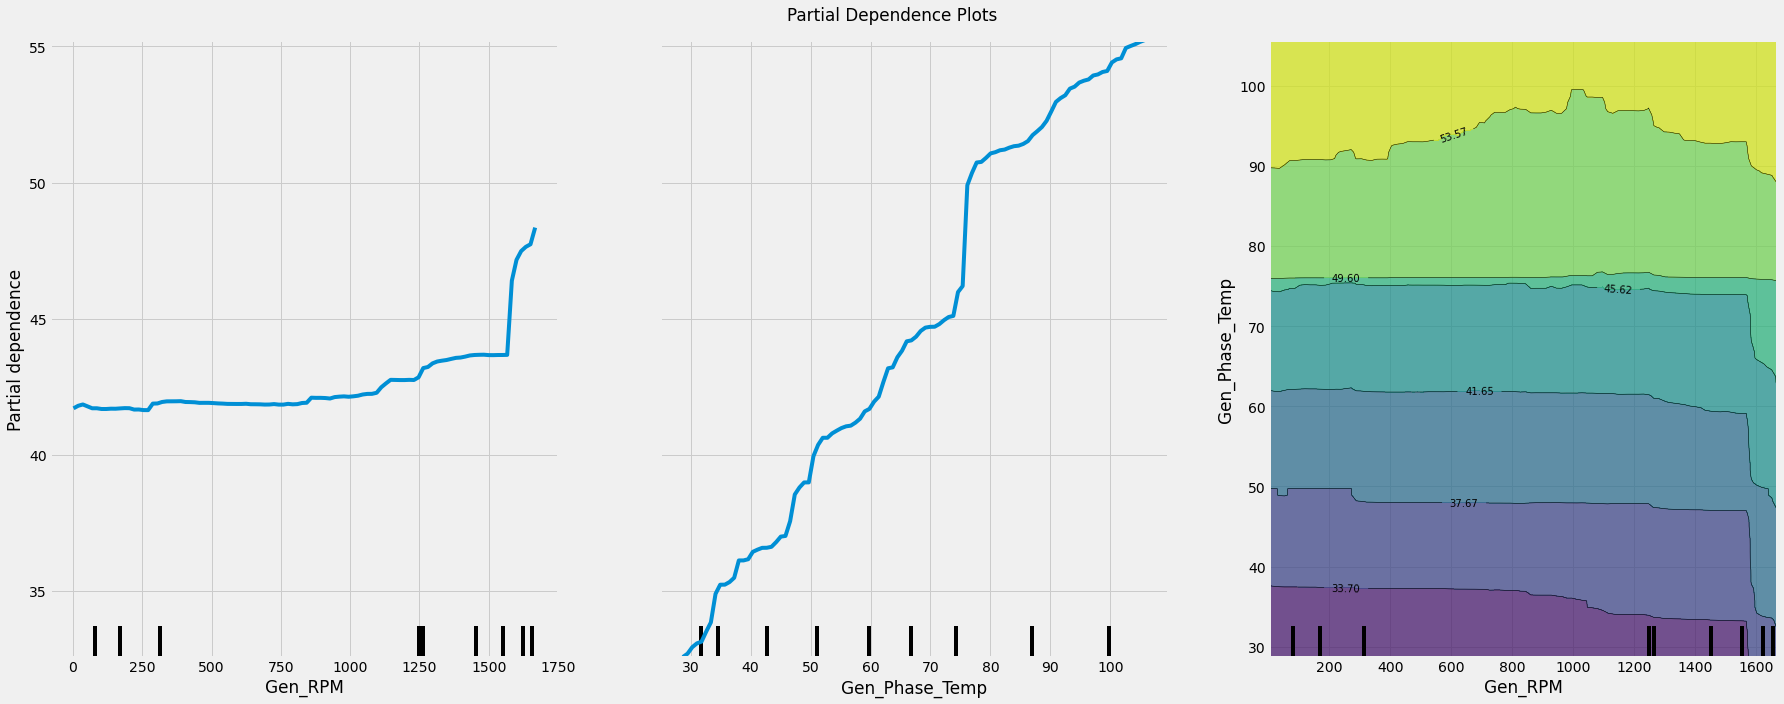

In [145]:
fig, ax = plt.subplots(figsize=(25, 10))
features = ['Gen_RPM', 'Gen_Phase_Temp', ('Gen_RPM', 'Gen_Phase_Temp')]
PartialDependenceDisplay.from_estimator(rf, X_train_dropped[:1000], features, ax=ax)
fig.suptitle('Partial Dependence Plots')
fig.tight_layout();

In [103]:
values = X_train[var].sort_values().unique()

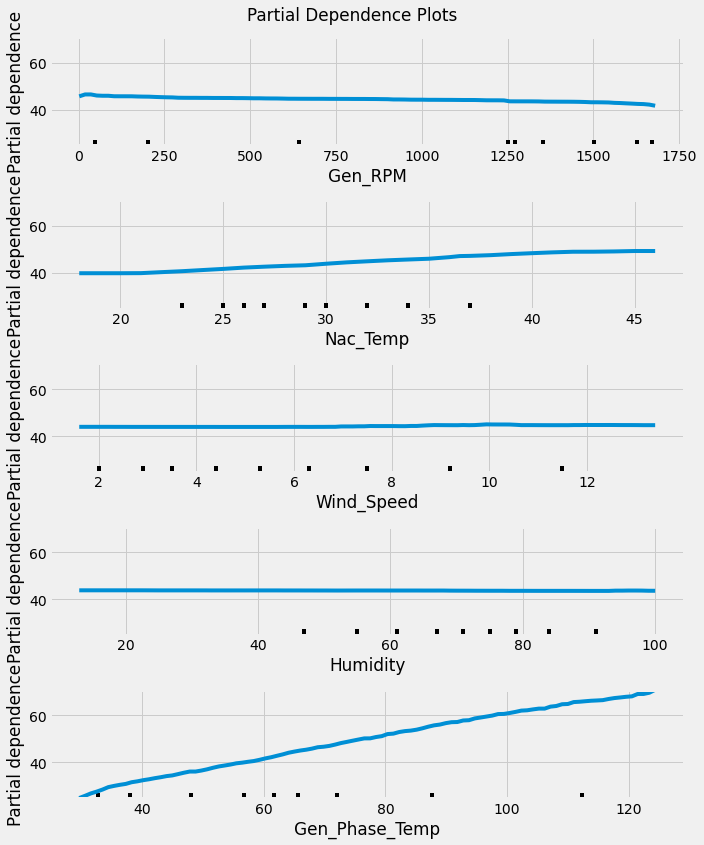

In [90]:
n_cols = 1
n_rows = int(len(X_train.columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 12))
PartialDependenceDisplay.from_estimator(XGB, X_train, X_train.columns, ax=ax, n_cols=n_cols)
fig.suptitle('Partial Dependence Plots')
fig.tight_layout();

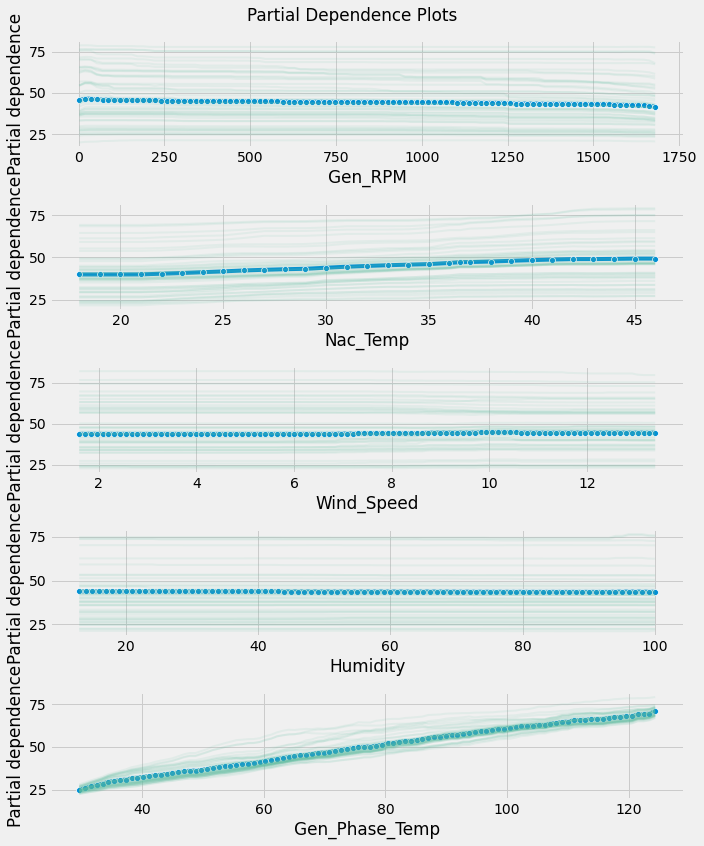

In [92]:
plt.figure(figsize=(10,12))
for i, x in enumerate(X_train.columns):
    raw_values = partial_dependence(XGB, X_train, i, kind='both')
    ax = plt.subplot(n_rows, n_cols, i+1)
    sns.lineplot(x=raw_values['values'][0], y=raw_values['average'][0], 
                 style=0, markers=True, legend=False, ax=ax)
    sns.lineplot(data=pd.DataFrame(raw_values['individual'][0], 
                                   columns=raw_values['values'][0])\
                        .sample(n).reset_index().melt('index'), 
                 x='variable', y='value', style='index', dashes=False, 
                 legend=False, alpha=0.1, size=1, color='#63C1A4')
    ax.set_xlabel(x)
    ax.set_ylabel('Partial dependence')
plt.suptitle('Partial Dependence Plots')
plt.tight_layout()

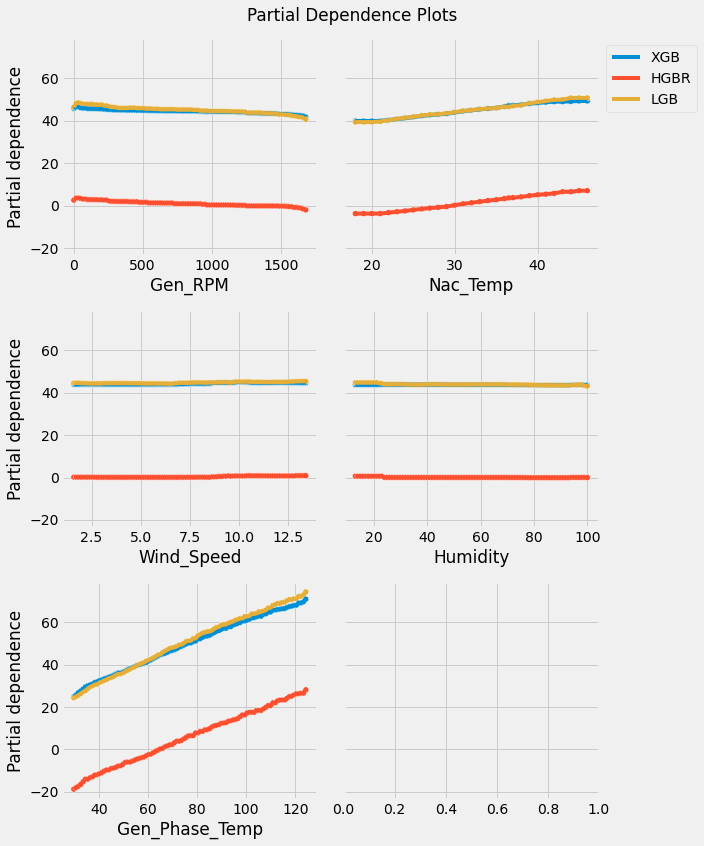

In [104]:
values = X_train[var].sort_values().unique()
n_rows = 3
n_cols = 2
summary = {}
fig, ax = plt.subplots(n_rows, n_cols, figsize=(10,12), sharey=True)
for i, x in enumerate(X_train.columns):
    summary[x] = pd.DataFrame(columns=values)
    raw_values = partial_dependence(XGB, X_train, x, kind='average')
    summary[x] = pd.DataFrame(columns=raw_values['values'][0])
    summary[x].loc['XGB'] = raw_values['average'][0]
    summary[x].loc['HGBR'] = partial_dependence(
        HGBR, X_train, x, kind='average'
    )['average'][0]
    summary[x].loc['LGB'] = partial_dependence(
        LGB, X_train, x, kind='average'
    )['average'][0]
    
    data = summary[x].reset_index().melt('index')
    loc = i//n_cols, i%n_cols
    if i==1:
        sns.lineplot(data=data, x='variable', y='value', 
                     hue='index',ax=ax[loc]);
        ax[loc].legend(bbox_to_anchor=(1, 1));
    else: 
        sns.lineplot(data=data, x='variable', y='value', 
                     hue='index', ax=ax[loc], legend=False);
    sns.scatterplot(data=data, x='variable', y='value', 
                    hue='index', ax=ax[loc], legend=False)
    ax[loc].set_xlabel(x)
    if i%n_cols==0:
        ax[loc].set_ylabel('Partial dependence')
fig.suptitle('Partial Dependence Plots')
fig.tight_layout()